# For existing experiment data, forward propagate the next few projections 

In [2]:
try:
    from mumott.data_handling import DataContainer
except:
    !sh ../scripts/setup.sh

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [3]:
import mumott
print(mumott.__version__)

2.2


In [4]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
from mumott.methods.projectors import SAXSProjectorCUDA, SAXSProjector
import numpy as np
import matplotlib.pyplot as plt
import torch
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

In [5]:
#load data
dc = DataContainer('/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5')
# dc = DataContainer('/das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5', nonfinite_replacement_value=0.0)

INFO:Rotation matrices were loaded from the input file.


/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:228: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:237: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:247: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:269: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/opt/conda/lib/python3.10/site-packages/mumott/data_handling/data_container.py:279: DeprecationWarning: Entry name offset_k is deprecated. Use k_offset instead.
  _deprecated_key_warning('offset_k'

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [6]:
#save copy of origial geometry
projections = dc.projections
dc_copy = copy.deepcopy(dc)
geometry_real = dc_copy.geometry
rotations_real = dc_copy.geometry.rotations
joff = dc_copy.geometry.j_offsets
koff = dc_copy.geometry.k_offsets

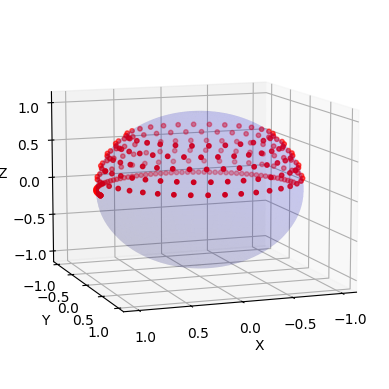

In [7]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

# mumott reconstruction

In [8]:
import h5py
from IPython.display import display
# from ipywidgets import interact
from mumott.data_handling import DataContainer
from mumott.output_handling import ProjectionViewer
from mumott.output_handling.saving import dict_to_h5
from mumott.methods.basis_sets import SphericalHarmonics, GaussianKernels
from mumott.methods.projectors import SAXSProjector as SAXSProjector
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

In [9]:
import torch
basis_set = SphericalHarmonics(ell_max=8)
projector = SAXSProjector(dc.geometry)
ResidualCalculator = GradientResidualCalculator(
                                data_container=dc,
                                basis_set=basis_set,
                                projector=projector)
loss_function = SquaredLoss(ResidualCalculator)
regularizer = Laplacian()
loss_function.add_regularizer(name='laplacian',
                              regularizer=regularizer,
                              regularization_weight=1)
optimizer = LBFGS(loss_function, maxiter=10)
results = optimizer.optimize()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:32<00:00, 27.23s/it]


In [10]:
results['x'].shape

(65, 82, 65, 45)

In [11]:
from mumott_plotting.tomogram_plots import plot_scalar_slices
from ipywidgets import interact
@interact(i=(0, results['x'].shape[0]-1), j=(0, results['x'].shape[1]-1), k=(0, results['x'].shape[2]-1))
def plot_slices(i, j, k):
    fig, axs = plot_scalar_slices(results['x'][..., 0], poi=(i, j, k))
    fig.show()

interactive(children=(IntSlider(value=32, description='i', max=64), IntSlider(value=40, description='j', max=8…

# forward propagation

In [12]:
projector = SAXSProjector(dc.geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=dc.geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(results['x'].astype(np.float64)))

# Create sparse subsets

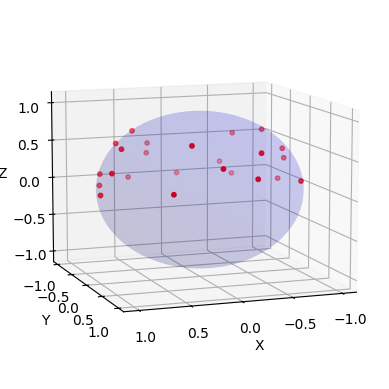

In [13]:
dc_copy = copy.deepcopy(dc)
projections = dc_copy.projections

# indices are calculated based on max-min sampling strategy, then m decides how many projections for reconstruction, n decides how many next projections for prediction
m = 60
n = 5


indices_first_120 = np.arange(len(dc_copy.geometry))
indices_to_keep = indices_first_120[::10]
indices_to_delete = [i for i in range(len(dc_copy.geometry)) if i not in indices_to_keep]
for i in sorted(indices_to_delete, reverse=True):
    del projections[i]


#plot original projections
rotation_angles_rad = dc_copy.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc_copy.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

# Synthetic Projection Generation

Using functions from the `mumott_al` library to create new geometries with arbitrary projection directions and generate synthetic projections from a reconstruction.

In [14]:
# Import geometry and projection generation functions from mumott_al library
import sys
sys.path.insert(0, '/myhome/smartt')

from mumott_al import (
    fibonacci_hemisphere,
    cartesian_to_spherical,
    create_geometry_from_directions,
    create_synthetic_projections,
    generate_geometry_and_projections,
    create_synthetic_data_container,
    generate_and_save_synthetic_data,
)

print("Imported mumott_al geometry functions successfully!")
print("Available functions:")
print("- fibonacci_hemisphere(n_points, upper=True)")
print("- cartesian_to_spherical(xyz)")
print("- create_geometry_from_directions(directions, reference_geometry, ...)")
print("- create_synthetic_projections(reconstruction, new_geometry, ...)")
print("- generate_geometry_and_projections(reconstruction, directions, reference_geometry, ...)")
print("- create_synthetic_data_container(geometry, projection_stack, reference_dc, save_path)")
print("- generate_and_save_synthetic_data(reconstruction, directions, reference_dc, ell_max, save_path)")

Imported mumott_al geometry functions successfully!
Available functions:
- fibonacci_hemisphere(n_points, upper=True)
- cartesian_to_spherical(xyz)
- create_geometry_from_directions(directions, reference_geometry, ...)
- create_synthetic_projections(reconstruction, new_geometry, ...)
- generate_geometry_and_projections(reconstruction, directions, reference_geometry, ...)
- create_synthetic_data_container(geometry, projection_stack, reference_dc, save_path)
- generate_and_save_synthetic_data(reconstruction, directions, reference_dc, ell_max, save_path)


## Test: Generate 20 evenly sampled projections on the top hemisphere

In [15]:
# Generate 20 evenly sampled points on the top hemisphere
n_new_projections = 20
new_directions = fibonacci_hemisphere(n_new_projections, upper=True)

print(f"Generated {len(new_directions)} directions on the upper hemisphere")
print(f"Direction shape: {new_directions.shape}")
print(f"\nFirst 5 directions (x, y, z):")
print(new_directions[:5])

# Convert to spherical coordinates for verification
inner_angles_new, outer_angles_new = cartesian_to_spherical(new_directions)
print(f"\nFirst 5 directions as (inner_angle, outer_angle) in degrees:")
for i in range(5):
    print(f"  [{np.degrees(inner_angles_new[i]):7.2f}°, {np.degrees(outer_angles_new[i]):7.2f}°]")

Generated 20 directions on the upper hemisphere
Direction shape: (20, 3)

First 5 directions (x, y, z):
[[ 0.          0.          1.        ]
 [-0.23309985  0.21353856  0.94871795]
 [ 0.03856741 -0.43945576  0.8974359 ]
 [ 0.32426062  0.42294056  0.84615385]
 [-0.5975019  -0.10568967  0.79487179]]

First 5 directions as (inner_angle, outer_angle) in degrees:
  [   0.00°,    0.00°]
  [ 137.51°,   18.43°]
  [ -84.98°,   26.18°]
  [  52.52°,   32.20°]
  [-169.97°,   37.36°]


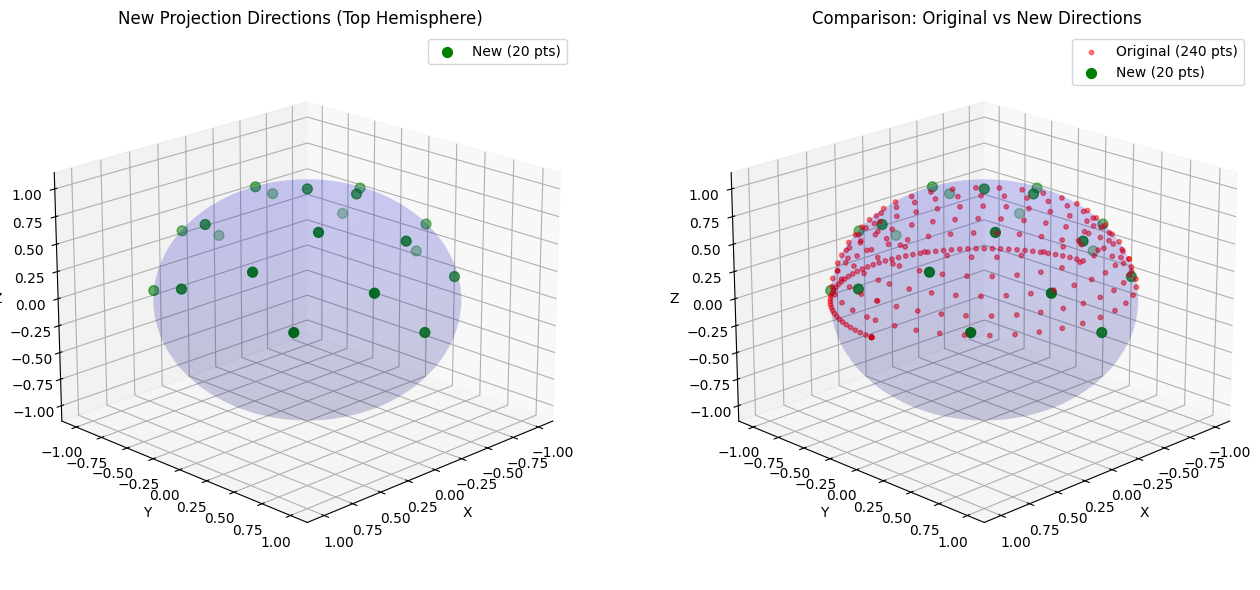

In [16]:
# Visualize the new projection directions alongside the original ones
fig = plt.figure(figsize=(14, 6))

# Plot 1: New directions only
ax1 = fig.add_subplot(121, projection='3d')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = np.outer(np.cos(u), np.sin(v))
Y = np.outer(np.sin(u), np.sin(v))
Z = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(X, Y, Z, color='b', alpha=0.1)
ax1.scatter(new_directions[:, 0], new_directions[:, 1], new_directions[:, 2], 
            color='g', s=50, label=f'New ({n_new_projections} pts)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('New Projection Directions (Top Hemisphere)')
ax1.legend()
ax1.view_init(elev=20, azim=45)

# Plot 2: Original directions for comparison
ax2 = fig.add_subplot(122, projection='3d')
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2 - np.array(dc.geometry.outer_angles))[:]
x_orig = np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y_orig = np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z_orig = np.cos(tilt_angles_rad)
ax2.plot_surface(X, Y, Z, color='b', alpha=0.1)
ax2.scatter(x_orig, y_orig, z_orig, color='r', s=10, alpha=0.5, label=f'Original ({len(x_orig)} pts)')
ax2.scatter(new_directions[:, 0], new_directions[:, 1], new_directions[:, 2], 
            color='g', s=50, label=f'New ({n_new_projections} pts)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Comparison: Original vs New Directions')
ax2.legend()
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

In [17]:
# Create new geometry and synthetic projections using the reconstruction
# Note: This requires 'results' from the mumott reconstruction to be available
# If you haven't run the reconstruction, run the cells above first

# Create new geometry with 20 hemisphere points
# IMPORTANT: Use return_data_container=True to get a ProjectionStack instead of numpy array
new_geometry, synthetic_projection_stack = generate_geometry_and_projections(
    reconstruction=results['x'],
    directions=new_directions,
    reference_geometry=dc.geometry,
    ell_max=8,
    return_data_container=True,  # Changed to True to get ProjectionStack
)

# Now create the DataContainer from the geometry and projection stack
new_dc = create_synthetic_data_container(new_geometry, synthetic_projection_stack, dc)

print(f"New geometry created with {len(new_geometry.inner_angles)} projections")
print(f"New DataContainer created with {len(new_dc.projections)} projections")
print(f"Synthetic data shape: {new_dc.data.shape}")
print(f"Reference (original) data shape: {dc.projections.data.shape}")

New geometry created with 20 projections
New DataContainer created with 20 projections
Synthetic data shape: (20, 73, 100, 8)
Reference (original) data shape: (240, 73, 100, 8)


In [18]:
dc.geometry

Field,Size,Data
rotations,240,e61813 (hash)
j_offsets,240,25a48a (hash)
k_offsets,240,30ee4a (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[1. 0. 0.]
k_direction_0,3,[0. 1. 0.]
inner_angles,240,a82439 (hash)
outer_angles,240,8460c7 (hash)
inner_axes,240,eeafe5 (hash)
outer_axes,240,cb1331 (hash)


In [19]:
new_dc.geometry

Field,Size,Data
rotations,20,d55993 (hash)
j_offsets,20,2d9b63 (hash)
k_offsets,20,2d9b63 (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[1. 0. 0.]
k_direction_0,3,[0. 1. 0.]
inner_angles,20,b4d4c8 (hash)
outer_angles,20,6de23a (hash)
inner_axes,20,d74487 (hash)
outer_axes,20,3814f0 (hash)


In [20]:
projector = SAXSProjector(new_dc.geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=new_dc.geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(results['x'].astype(np.float64)))
forward_projections.shape

(20, 73, 100, 8)

In [22]:
import torch
basis_set = SphericalHarmonics(ell_max=8)
projector_new = SAXSProjector(new_dc.geometry)
ResidualCalculator = GradientResidualCalculator(
                                data_container=new_dc,
                                basis_set=basis_set,
                                projector=projector_new)
loss_function = SquaredLoss(ResidualCalculator)
regularizer = Laplacian()
loss_function.add_regularizer(name='laplacian',
                              regularizer=regularizer,
                              regularization_weight=1)
optimizer = LBFGS(loss_function, maxiter=20)
results_new = optimizer.optimize()

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [01:03<00:27,  4.57s/it]


In [ ]:
from mumott_plotting.tomogram_plots import plot_scalar_slices
from ipywidgets import interact
@interact(i=(0, results_new['x'].shape[0]-1), j=(0, results_new['x'].shape[1]-1), k=(0, results_new['x'].shape[2]-1))
def plot_slices(i, j, k):
    fig, axs = plot_scalar_slices(results_new['x'][..., 0], poi=(i, j, k))
    fig.show()

interactive(children=(IntSlider(value=32, description='i', max=64), IntSlider(value=40, description='j', max=8…

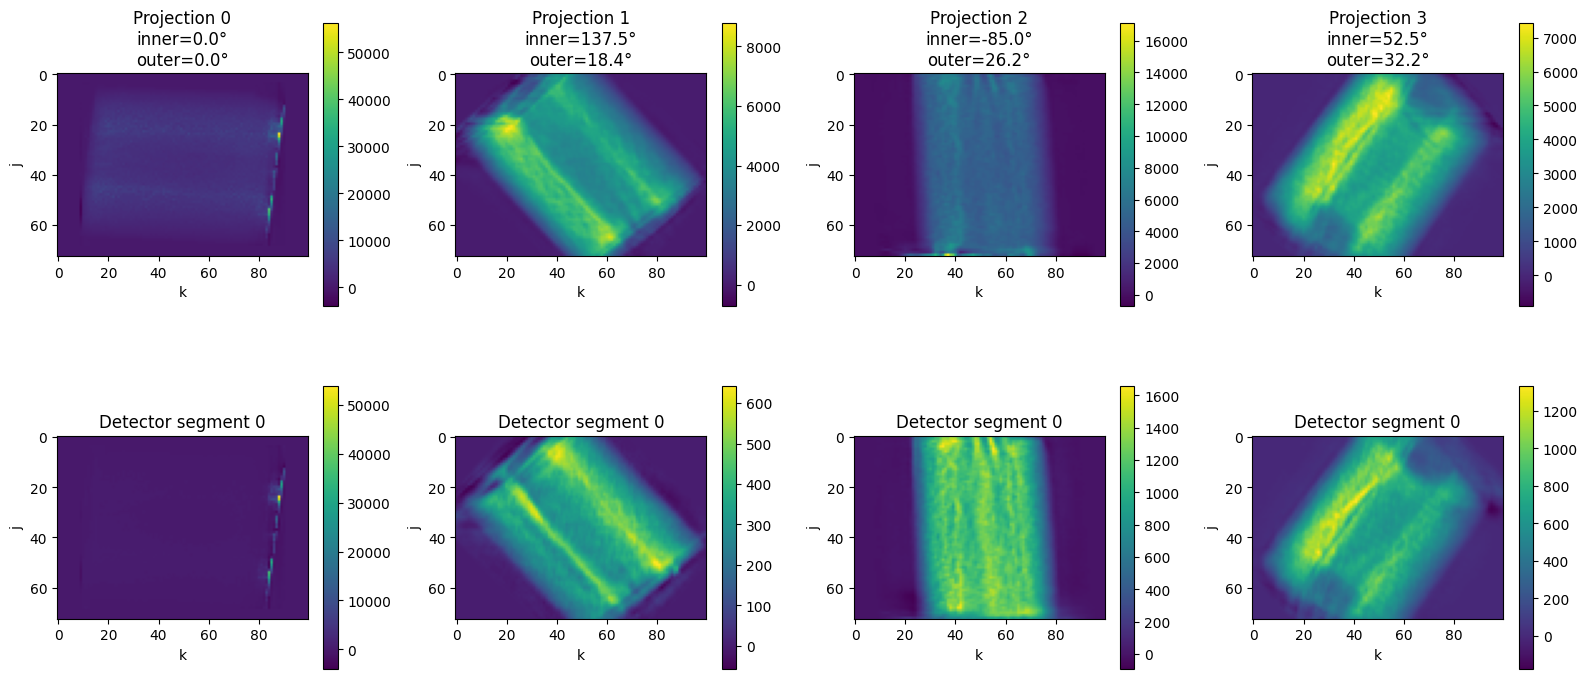

Projection data statistics:
  Min: -4011.0923
  Max: 53923.4152
  Mean: 358.9979


In [23]:
synthetic_projections = forward_projections

# Visualize a few synthetic projections
n_show = min(4, len(synthetic_projections))
fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for i in range(n_show):
    # Show sum over detector segments (integrated signal)
    ax_top = axes[0, i]
    im = ax_top.imshow(synthetic_projections[i].sum(axis=-1), cmap='viridis')
    ax_top.set_title(f'Projection {i}\ninner={np.degrees(new_geometry.inner_angles[i]):.1f}°\nouter={np.degrees(new_geometry.outer_angles[i]):.1f}°')
    ax_top.set_xlabel('k')
    ax_top.set_ylabel('j')
    plt.colorbar(im, ax=ax_top, shrink=0.7)
    
    # Show first detector segment
    ax_bottom = axes[1, i]
    im = ax_bottom.imshow(synthetic_projections[i, :, :, 0], cmap='viridis')
    ax_bottom.set_title(f'Detector segment 0')
    ax_bottom.set_xlabel('k')
    ax_bottom.set_ylabel('j')
    plt.colorbar(im, ax=ax_bottom, shrink=0.7)

plt.tight_layout()
plt.show()

print(f"Projection data statistics:")
print(f"  Min: {synthetic_projections.min():.4f}")
print(f"  Max: {synthetic_projections.max():.4f}")
print(f"  Mean: {synthetic_projections.mean():.4f}")

## Create a full DataContainer with synthetic projections

In [24]:
# Create a complete DataContainer-like structure with the synthetic projections
# This creates a ProjectionStack that can be used similar to dc.projections

new_geometry_full, synthetic_projection_stack = generate_geometry_and_projections(
    reconstruction=results['x'],
    directions=new_directions,
    reference_geometry=dc.geometry,
    ell_max=8,
    return_data_container=True,  # Return ProjectionStack instead of array
)

print(f"Created ProjectionStack with {len(synthetic_projection_stack)} projections")
print(f"Data shape: {synthetic_projection_stack.data.shape}")
print(f"Geometry inner angles: {len(synthetic_projection_stack.geometry.inner_angles)} projections")
print(f"\nThis ProjectionStack can be used like dc.projections for further processing.")

Created ProjectionStack with 20 projections
Data shape: (20, 73, 100, 8)
Geometry inner angles: 20 projections

This ProjectionStack can be used like dc.projections for further processing.


# Reconstruction Comparison Metrics

Compare reconstructions using the metrics from `mumott_al`:
- **Coefficient-based**: MSE and normalized MSE of spherical harmonic coefficients
- **Projection-based**: MSE, PSNR, SSIM per detector channel and globally
- **Orientation-based**: Cosine similarity of principal directions (eigenvector_1)

In [25]:
# Import metrics from mumott_al
from mumott_al import (
    mse_coefficients,
    normalized_mse_coefficients,
    projection_metrics,
    orientation_similarity,
    compare_reconstructions,
)
from mumott_al.metrics import print_comparison_results

print("Imported mumott_al metrics functions successfully!")

Imported mumott_al metrics functions successfully!


In [ ]:
import importlib
import mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import compare_reconstructions, print_comparison_results, real_space_metrics, RealSpaceMetricsResult

In [ ]:
# Compare results['x'] (full data reconstruction) with results_new['x'] (sparse hemisphere reconstruction)
# Note: results_new was reconstructed from only 20 synthetic hemisphere projections

print("Comparing reconstructions:")
print(f"  - results['x']: Reconstruction from full original data ({len(dc.geometry.inner_angles)} projections)")
print(f"  - results_new['x']: Reconstruction from synthetic hemisphere data ({len(new_dc.geometry.inner_angles)} projections)")
print(f"  - Both have shape: {results['x'].shape}")

# Run comprehensive comparison.
# dc.projections.weights has shape (n_projections, det_x, det_y);
# pixels with weight==0 are bad/masked detector pixels excluded from projection metrics.
comparison = compare_reconstructions(
    reconstruction_pred=results_new['x'],
    reconstruction_gt=results['x'],
    geometry=new_dc.geometry,  # Use new_dc geometry for projection comparison
    ell_max=8,
    mask=None,  # Could add a mask to focus on sample region
    weights=dc.projections.weights,  # exclude bad/masked detector pixels
    compute_projection_metrics=True,
    compute_orientation_metrics=True,
    compute_real_space_metrics=True,
    real_space_resolution_in_degrees=10,
    percentile_low=5.0,
    percentile_high=95.0,
)

# Print results
print_comparison_results(comparison)

Comparing reconstructions:
  - results['x']: Reconstruction from full original data (240 projections)
  - results_new['x']: Reconstruction from synthetic hemisphere data (20 projections)
  - Both have shape: (65, 82, 65, 45)


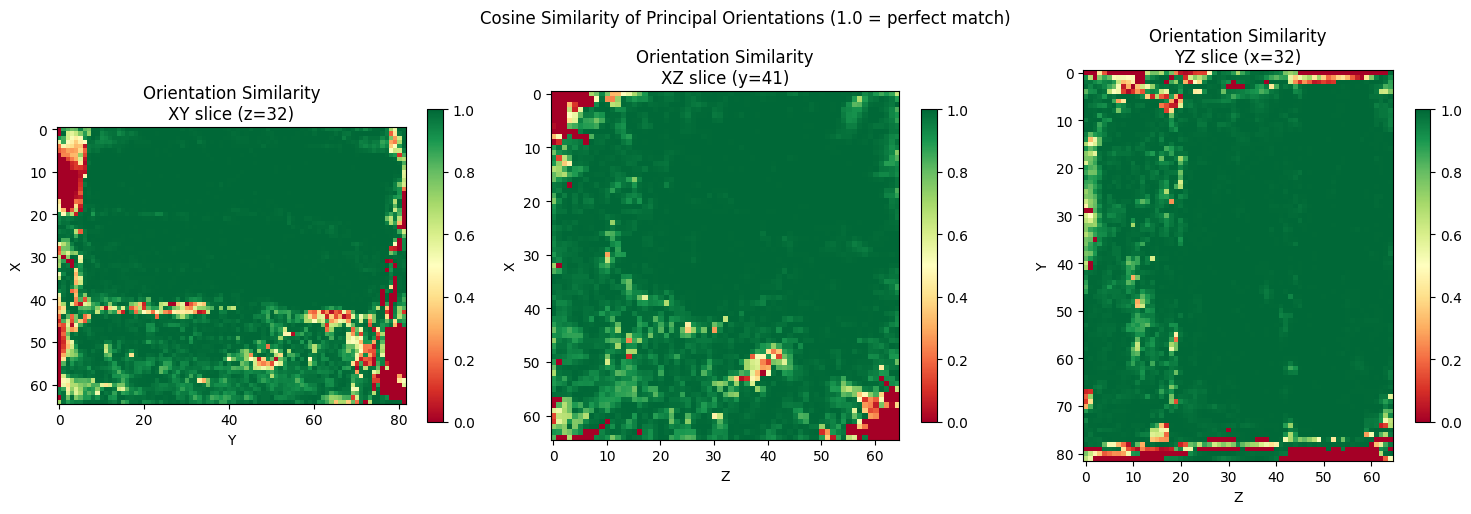

In [ ]:
# Visualize orientation similarity map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get middle slices
mid_x = results['x'].shape[0] // 2
mid_y = results['x'].shape[1] // 2
mid_z = results['x'].shape[2] // 2

cosine_map = comparison.orientation_metrics.cosine_similarity_map

# XY slice (middle z)
im0 = axes[0].imshow(cosine_map[:, :, mid_z], cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title(f'Orientation Similarity\nXY slice (z={mid_z})')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('X')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# XZ slice (middle y)
im1 = axes[1].imshow(cosine_map[:, mid_y, :], cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title(f'Orientation Similarity\nXZ slice (y={mid_y})')
axes[1].set_xlabel('Z')
axes[1].set_ylabel('X')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# YZ slice (middle x)
im2 = axes[2].imshow(cosine_map[mid_x, :, :], cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title(f'Orientation Similarity\nYZ slice (x={mid_x})')
axes[2].set_xlabel('Z')
axes[2].set_ylabel('Y')
plt.colorbar(im2, ax=axes[2], shrink=0.8)

plt.suptitle('Cosine Similarity of Principal Orientations (1.0 = perfect match)', fontsize=12)
plt.tight_layout()
plt.show()

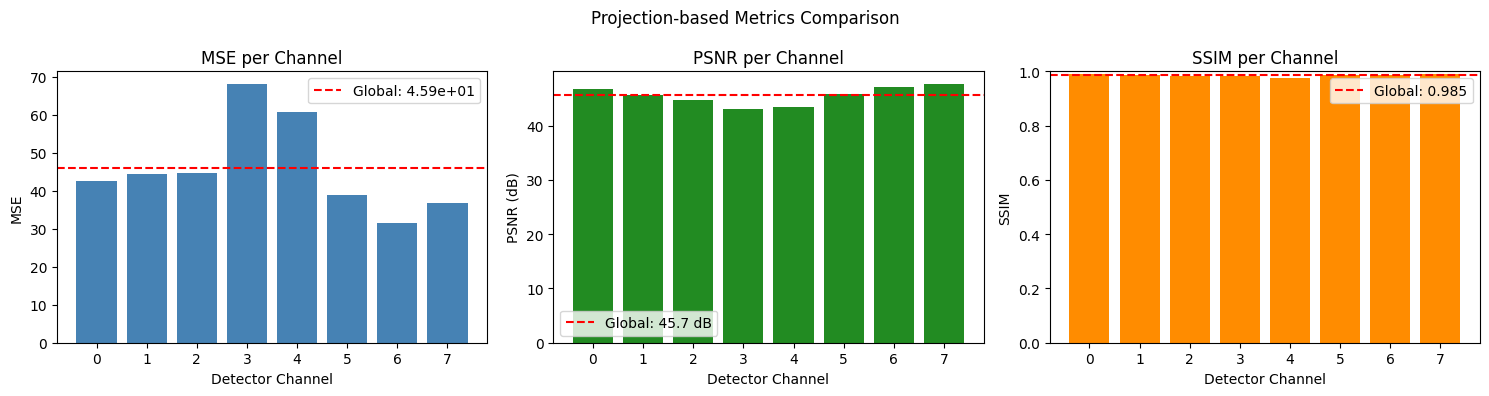

In [ ]:
# Visualize projection metrics per channel
pm = comparison.projection_metrics

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

channels = np.arange(pm.n_channels)

# MSE per channel
axes[0].bar(channels, pm.mse_per_channel, color='steelblue')
axes[0].axhline(pm.mse_global, color='red', linestyle='--', label=f'Global: {pm.mse_global:.2e}')
axes[0].set_xlabel('Detector Channel')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE per Channel')
axes[0].legend()

# PSNR per channel
axes[1].bar(channels, pm.psnr_per_channel, color='forestgreen')
axes[1].axhline(pm.psnr_global, color='red', linestyle='--', label=f'Global: {pm.psnr_global:.1f} dB')
axes[1].set_xlabel('Detector Channel')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_title('PSNR per Channel')
axes[1].legend()

# SSIM per channel
axes[2].bar(channels, pm.ssim_per_channel, color='darkorange')
axes[2].axhline(pm.ssim_global, color='red', linestyle='--', label=f'Global: {pm.ssim_global:.3f}')
axes[2].set_xlabel('Detector Channel')
axes[2].set_ylabel('SSIM')
axes[2].set_title('SSIM per Channel')
axes[2].set_ylim(0, 1)
axes[2].legend()

plt.suptitle('Projection-based Metrics Comparison', fontsize=12)
plt.tight_layout()
plt.show()

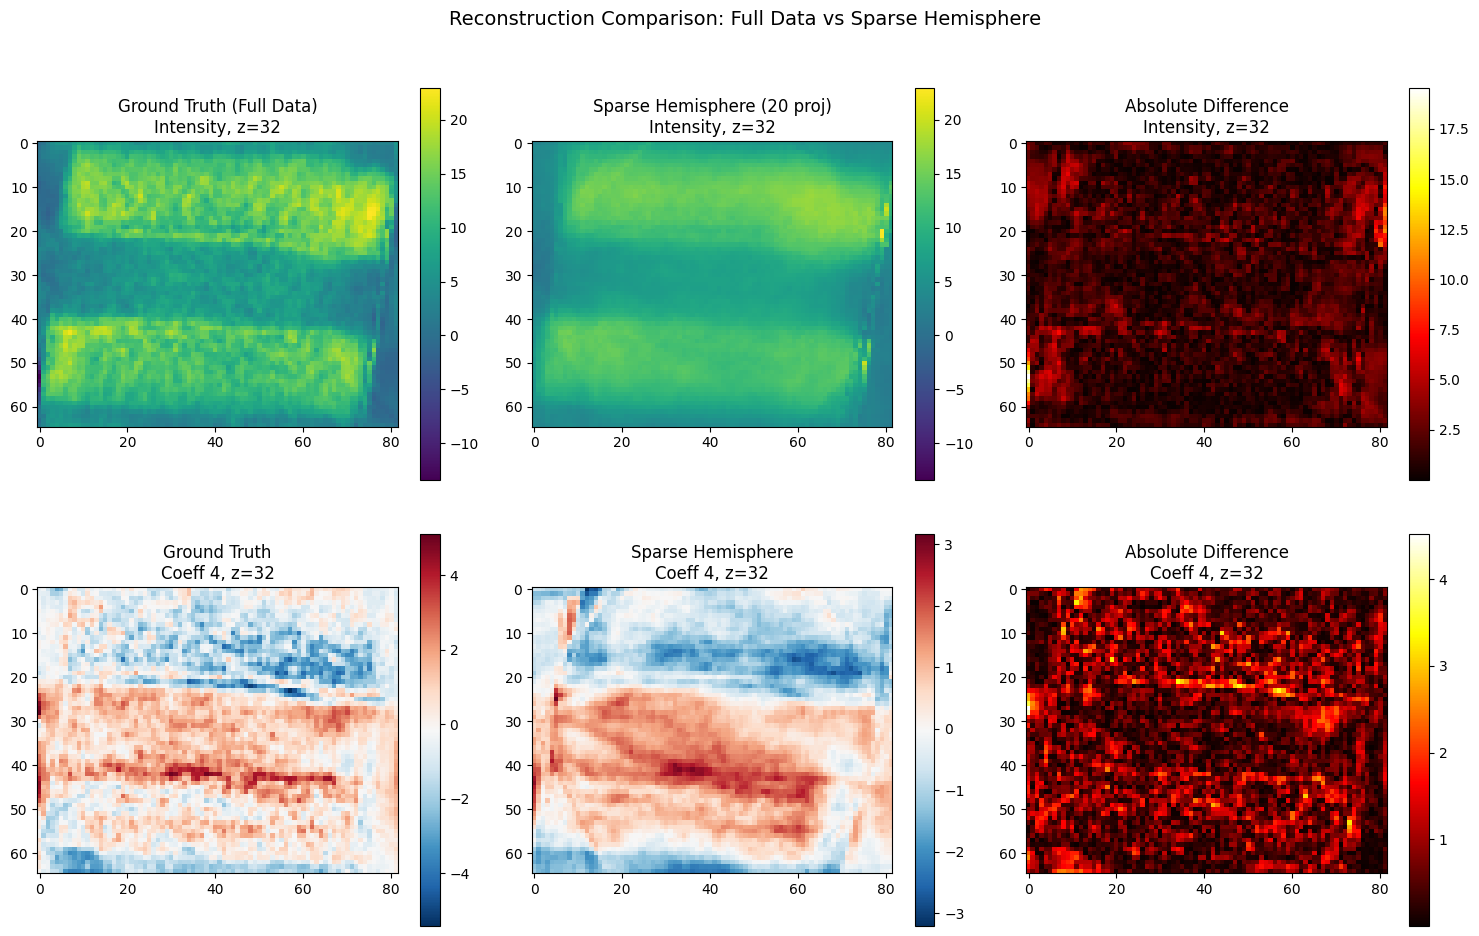

In [ ]:
# Side-by-side comparison of reconstructions (first coefficient - intensity)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

mid_z = results['x'].shape[2] // 2

# Ground truth (full data)
vmin = results['x'][:, :, mid_z, 0].min()
vmax = results['x'][:, :, mid_z, 0].max()
im00 = axes[0, 0].imshow(results['x'][:, :, mid_z, 0], cmap='viridis')
axes[0, 0].set_title(f'Ground Truth (Full Data)\nIntensity, z={mid_z}')
plt.colorbar(im00, ax=axes[0, 0], shrink=0.8)

im01 = axes[0, 1].imshow(results_new['x'][:, :, mid_z, 0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0, 1].set_title(f'Sparse Hemisphere (20 proj)\nIntensity, z={mid_z}')
plt.colorbar(im01, ax=axes[0, 1], shrink=0.8)

diff_intensity = np.abs(results['x'][:, :, mid_z, 0] - results_new['x'][:, :, mid_z, 0])
im02 = axes[0, 2].imshow(diff_intensity, cmap='hot')
axes[0, 2].set_title(f'Absolute Difference\nIntensity, z={mid_z}')
plt.colorbar(im02, ax=axes[0, 2], shrink=0.8)

# Second coefficient (anisotropy-related)
coeff_idx = 4  # Pick a higher-order coefficient
im10 = axes[1, 0].imshow(results['x'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 0].set_title(f'Ground Truth\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im10, ax=axes[1, 0], shrink=0.8)

im11 = axes[1, 1].imshow(results_new['x'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 1].set_title(f'Sparse Hemisphere\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im11, ax=axes[1, 1], shrink=0.8)

diff_coeff = np.abs(results['x'][:, :, mid_z, coeff_idx] - results_new['x'][:, :, mid_z, coeff_idx])
im12 = axes[1, 2].imshow(diff_coeff, cmap='hot')
axes[1, 2].set_title(f'Absolute Difference\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im12, ax=axes[1, 2], shrink=0.8)

plt.suptitle('Reconstruction Comparison: Full Data vs Sparse Hemisphere', fontsize=14)
plt.tight_layout()
plt.show()

## Projection residuals: predicted vs measured

Forward-project each reconstruction through the geometry of `dc` and compare the predictions against the measured projections stored in `dc`.  
Both **MSE** and **MAE** are shown per projection angle and per detector channel.

In [ ]:
import importlib
import mumott_al.visualization
importlib.reload(mumott_al.visualization)
from mumott_al.visualization import plot_projection_residuals, plot_projection_residuals_comparison

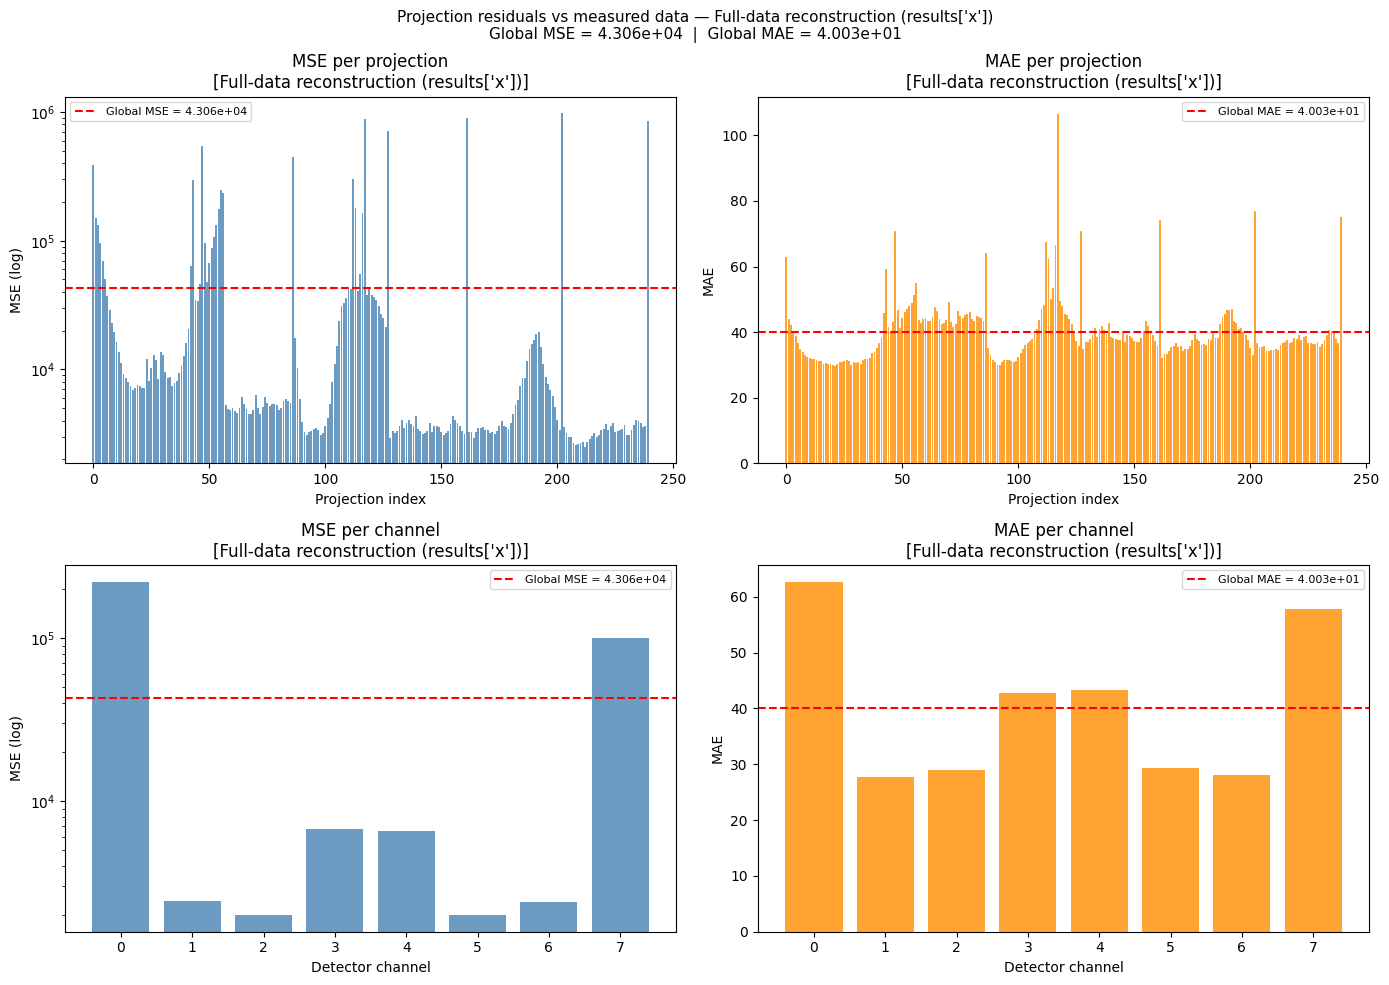

Global MSE: 4.3063e+04
Global MAE: 4.0032e+01


In [ ]:
# Projection residuals for results['x'] (full-data reconstruction) vs dc
fig1, axes1, stats1 = plot_projection_residuals(
    reconstruction=results['x'],
    data_container=dc,
    ell_max=8,
    label="Full-data reconstruction (results['x'])",
    log_scale_mse=True,
)
plt.show()

print(f"Global MSE: {stats1['global_mse']:.4e}")
print(f"Global MAE: {stats1['global_mae']:.4e}")

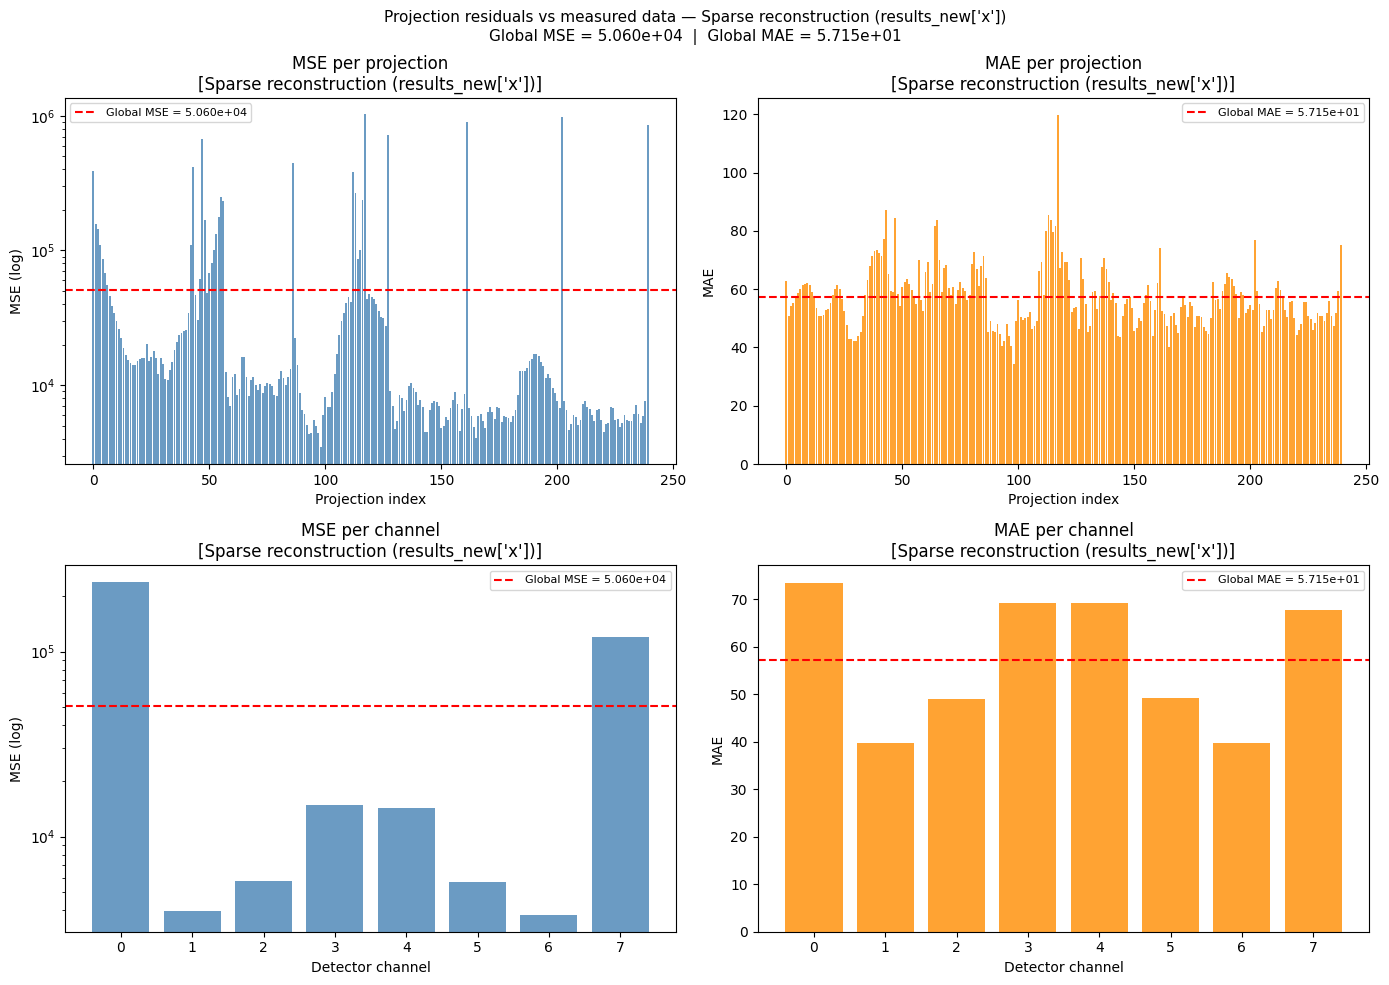

Global MSE: 5.0603e+04
Global MAE: 5.7147e+01


In [ ]:
# Projection residuals for results_new['x'] (sparse-hemisphere reconstruction) vs dc
fig2, axes2, stats2 = plot_projection_residuals(
    reconstruction=results_new['x'],
    data_container=dc,
    ell_max=8,
    label="Sparse reconstruction (results_new['x'])",
    log_scale_mse=True,
)
plt.show()

print(f"Global MSE: {stats2['global_mse']:.4e}")
print(f"Global MAE: {stats2['global_mae']:.4e}")

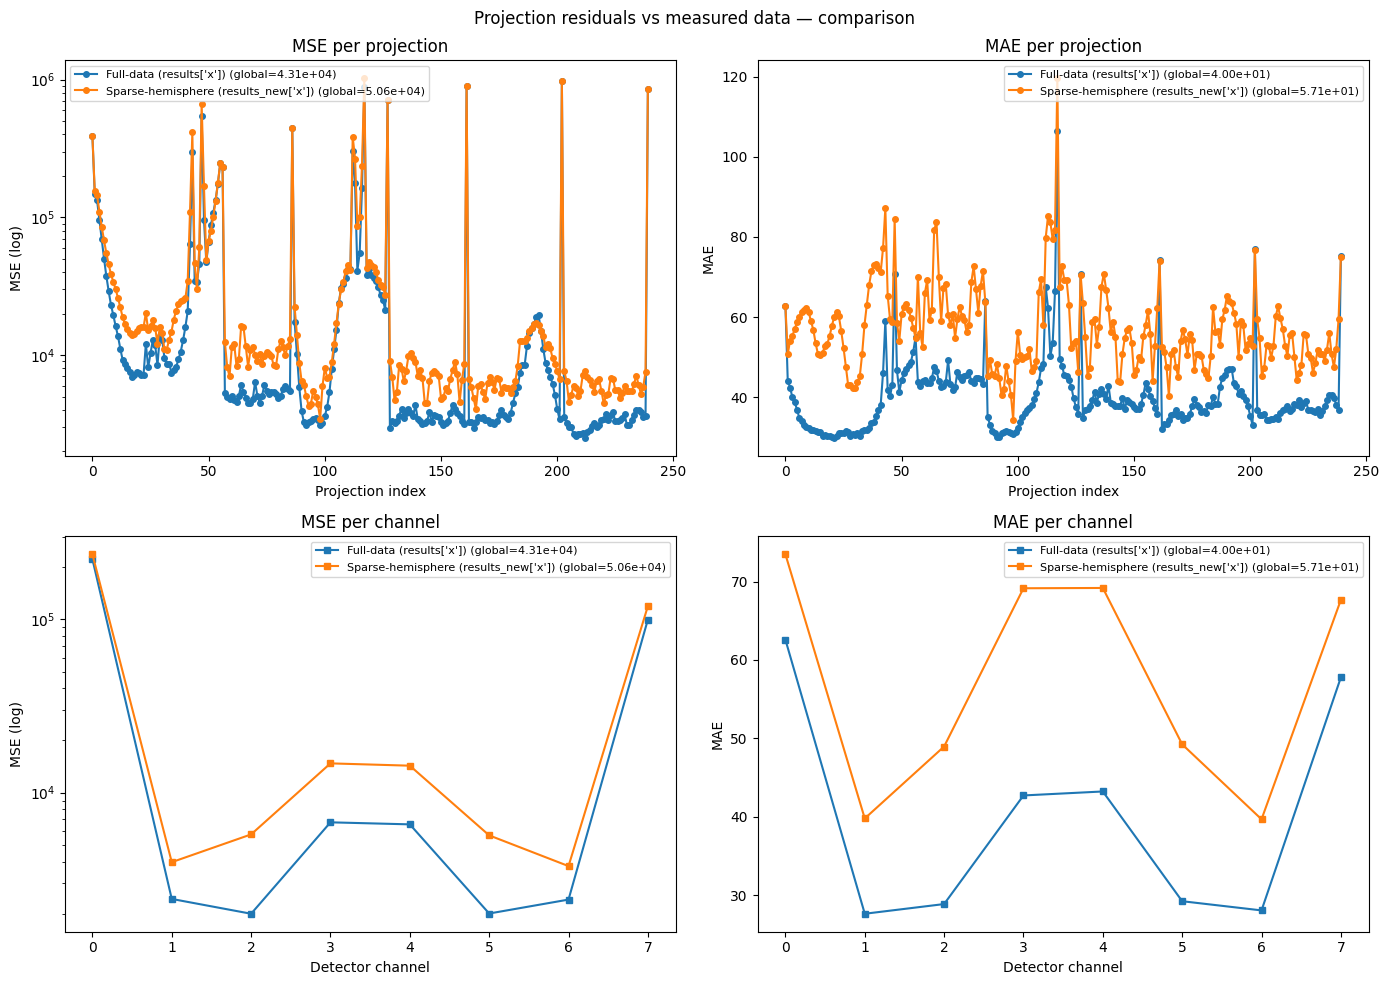

Reconstruction                             Global MSE   Global MAE
------------------------------------------------------------------
Full-data (results['x'])                   4.3063e+04   4.0032e+01
Sparse-hemisphere (results_new['x'])       5.0603e+04   5.7147e+01


In [ ]:
# Side-by-side comparison: both reconstructions on shared axes
fig3, axes3, all_stats = plot_projection_residuals_comparison(
    reconstructions={
        "Full-data (results['x'])": results['x'],
        "Sparse-hemisphere (results_new['x'])": results_new['x'],
    },
    data_container=dc,
    ell_max=8,
    log_scale_mse=True,
)
plt.show()

# Print summary table
print(f"{'Reconstruction':<40} {'Global MSE':>12} {'Global MAE':>12}")
print("-" * 66)
for lbl, st in all_stats.items():
    print(f"{lbl:<40} {st['global_mse']:>12.4e} {st['global_mae']:>12.4e}")

## Real-space SH Function Metrics (PSNR / SSIM)

Instead of comparing the 45 SH *coefficients* directly, we evaluate both reconstructions as real-valued functions on a spherical grid of directions and compute MSE, PSNR and SSIM on that representation.

The SH basis matrix is built once for the chosen angular resolution, then applied to every voxel via a single matrix multiplication — so the computation is fast even for large volumes.

* **resolution_in_degrees = 10** → ~370 directions on the upper hemisphere
* A coarser grid (e.g. 15°) is fine for a quick check; use 5° for high-fidelity comparison.

In [ ]:
import importlib
import mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import real_space_metrics, compare_reconstructions, print_comparison_results, RealSpaceMetricsResult

In [ ]:
# Compute real-space SH metrics between full-data and sparse reconstructions.
# resolution_in_degrees=10 gives ~370 directions on the upper hemisphere.
rs_result = real_space_metrics(
    reconstruction_pred=results_new['x'],
    reconstruction_gt=results['x'],
    ell_max=8,
    resolution_in_degrees=10,
    map_half_sphere=True,   # SH functions are symmetric → upper hemisphere suffices
    percentile_low=5.0,
    percentile_high=95.0,
)

print(f"Real-space SH Function Metrics  (grid: {rs_result.resolution_in_degrees}°, {rs_result.n_directions} directions)")
print(f"  MSE:  {rs_result.mse:.6e}")
print(f"  PSNR: {rs_result.psnr:.2f} dB")
print(f"  SSIM: {rs_result.ssim:.4f}")

In [ ]:
from mumott.methods.basis_sets import SphericalHarmonics
from mumott_plotting.map_plots import plot_on_polefigure

# Pick a voxel with non-trivial anisotropy in the ground-truth reconstruction
gt_vol = results['x']
aniso = np.sum(gt_vol[..., 1:] ** 2, axis=-1)
flat_idx = np.argmax(aniso)
ix, iy, iz = np.unravel_index(flat_idx, gt_vol.shape[:3])
print(f"Most anisotropic voxel: ({ix}, {iy}, {iz})")

bs = SphericalHarmonics(ell_max=8)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'polar': True})
for ax, vol, label in zip(
    axes,
    [results['x'], results_new['x']],
    ["Full-data recon (GT)", "Sparse-hemisphere recon"],
):
    coeffs = vol[ix, iy, iz, :]
    intensity, theta, phi = bs.generate_map(coeffs, resolution_in_degrees=3, map_half_sphere=True)
    plot_on_polefigure(ax, intensity, theta, phi)
    ax.set_title(label)

fig.suptitle(f"Real-space SH function at voxel ({ix}, {iy}, {iz})", fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# Summary bar chart: compare real-space results at different angular resolutions
resolutions = [15, 10, 5]
rs_results = {}
for res in resolutions:
    rs_results[res] = real_space_metrics(
        reconstruction_pred=results_new['x'],
        reconstruction_gt=results['x'],
        ell_max=8,
        resolution_in_degrees=res,
        map_half_sphere=True,
    )
    print(f"  {res:2d}° ({rs_results[res].n_directions:4d} dirs) | "
          f"MSE {rs_results[res].mse:.4e} | "
          f"PSNR {rs_results[res].psnr:.2f} dB | "
          f"SSIM {rs_results[res].ssim:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = [f"{r}° ({rs_results[r].n_directions} dirs)" for r in resolutions]

axes[0].bar(labels, [rs_results[r].psnr for r in resolutions], color='steelblue')
axes[0].set_ylabel("PSNR (dB)")
axes[0].set_title("Real-space PSNR vs grid resolution")
axes[0].grid(True, axis='y', alpha=0.4)

axes[1].bar(labels, [rs_results[r].ssim for r in resolutions], color='coral')
axes[1].set_ylabel("SSIM")
axes[1].set_title("Real-space SSIM vs grid resolution")
axes[1].set_ylim(0, 1)
axes[1].grid(True, axis='y', alpha=0.4)

plt.tight_layout()
plt.show()